In [1]:
import os
import sys
from pathlib import Path
from collections import Counter
import h5py
import time
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torchinfo import summary
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt

In [2]:
# ------------------ Config ------------------
class CFG:
    data_path = "/kaggle/input/galaxy10-decals/Galaxy10_DECals.h5"
    batch_size = 64
    num_workers = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    num_epochs = 20
    seed = 42
    out_dir = "/kaggle/working/galaxy10_experiments"
    plot_dir = "/kaggle/working/galaxy10_plots"
    experiments_summary_csv = os.path.join(out_dir, "experiments_summary.csv")
    experiments_with_balanced_csv = os.path.join(out_dir, "experiments_with_balanced.csv")
    experiments_with_imbalanced_csv = os.path.join(out_dir, "experiments_with_imbalanced.csv")
    use_data_parallel = True  # Use multi-GPU if available
    run = 0
    
os.makedirs(CFG.plot_dir, exist_ok=True)

In [3]:
# ------------------ Reproducibility ------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

In [4]:
# ------------------ Dataset ------------------
class GalaxyH5Dataset(Dataset):
    def __init__(self, images_array, labels_array, indices, transform=None):
        self.images = images_array
        self.labels = labels_array
        self.indices = np.array(indices, dtype=np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img = self.images[real_idx]  # HWC, uint8
        # Convert to PIL Image
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)  # guard if floats in [0,1]
        pil = Image.fromarray(img)
        label = int(self.labels[real_idx])
        if self.transform:
            pil = self.transform(pil)
        return pil, label

In [5]:
# ------------------ Transforms ------------------
def get_transforms():
    # ImageNet normalization
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD  = [0.229, 0.224, 0.225]
    
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.RandomApply([transforms.RandomRotation(30)], p=0.33),  # Random rotation with p=0.33
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.33),  # Random contrast/brightness with p=0.33
        transforms.RandomHorizontalFlip(p=0.33),  # Random horizontal flip with p=0.33
        transforms.RandomVerticalFlip(p=0.33),  # Random vertical flip with p=0.33
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
    return train_transform, val_transform

In [6]:
# ------------------ Model Factory ------------------
def build_model(model_name="densenet121", num_classes=10, pretrained=True):
    if model_name == "densenet121":
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.densenet121(weights=weights)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    # elif model_name == "resnet50":
    #     model = models.resnet50(pretrained=True)
    #     model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Unsupported model")
    return model

In [7]:
# ------------------ Training & Validation ------------------
def train_one_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss=0.0
    preds = []
    targs = []
    n = 0

    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        n += images.size(0)
        
        preds_batch = outputs.argmax(dim=1).detach().cpu().numpy()
        preds.extend(preds_batch.tolist())
        targs.extend(labels.detach().cpu().numpy().tolist())

    epoch_loss = running_loss / n
    epoch_acc = accuracy_score(targs, preds)
    
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds = []
    targs = []
    n = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with autocast(device_type = "cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            n += images.size(0)
            preds.extend(outputs.argmax(dim=1).detach().cpu().numpy().tolist())
            targs.extend(labels.detach().cpu().numpy().tolist())
    epoch_loss = running_loss / n
    epoch_acc = accuracy_score(targs, preds)

    return epoch_loss, epoch_acc, np.array(targs), np.array(preds)

In [ ]:
# ------------------ Function to Display 1 image from each class ------------------
def display_dataset(images, labels):
    CLASS_NAMES = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth Galaxies",
    "In-between Round Smooth Galaxies",
    "Cigar Shaped Smooth Galaxies",
    "Barred Spiral Galaxies",
    "Unbarred Tight Spiral Galaxies",
    "Unbarred Loose Spiral Galaxies",
    "Edge-on Galaxies without Bulge",
    "Edge-on Galaxies with Bulge"
]
    sample_per_class = {}
    # Loop through dataset to find one image per class
    for img, label in zip(images, labels):
        if label not in sample_per_class:
            sample_per_class[label] = img
        if len(sample_per_class) == 10:
            break
    
    # Plot one image per class
    plt.figure(figsize=(18, 6))
    plt.xticks([])
    plt.yticks([])
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_per_class[i])
        plt.title(f"{CLASS_NAMES[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(CFG.plot_dir,"Dataset Classes.png"))
    plt.show()

In [ ]:
# Load .h5 file (images and labels) and show dataset summary

def read_dataset(h5_path):
    with h5py.File(h5_path, "r") as f:
        # Inspect keys
        #print("HDF5 keys:", list(f.keys()))
        # Common structure for Galaxy10_DECals: 'images' and 'ans'
        # but sometimes keys differ; attempt robust extraction
        if "images" in f:
            images_ds = f["images"][:]
        
        # labels
        if "ans" in f:
            labels_ds = f["ans"][:]
        elif "labels" in f:
            labels_ds = f["labels"][:]
        
    #print("Images shape:", images_ds.shape)
    #print("Labels shape:", labels_ds.shape)
    assert images_ds.shape[0] == labels_ds.shape[0], "Image count and label count mismatch"
    N = images_ds.shape[0]
    #print("Total samples:", N)
    class_counts = Counter(labels_ds.tolist())
    #print("Class distribution (label:count):", dict(class_counts))
    num_classes = len(sorted(set(labels_ds.tolist())))
    #print("Detected num classes:", num_classes)

    #Build a DataFrame index for stratified splitting (lightweight)
    df = pd.DataFrame({"idx": np.arange(N), "label": labels_ds})
    
    return images_ds, labels_ds, df

In [ ]:
# ------------------ Function to plot Training History ------------------

def plot_training_history(exp, history):
    epochs = history["epoch"]

    # Plot Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    # Plot Learning Rate
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["lr"], label="Learning Rate")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.title("Learning Rate Schedule")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    plt.savefig(os.path.join(CFG.plot_dir,f"{exp}_training_history.png"))
    
    plt.show()    

In [ ]:
# ------------------ Function to plot Confusion Matrix ------------------

def plot_confusion_matrix(exp, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(10))

    # Plot the Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{exp}")
    
    # Save the Plot
    plt.savefig(os.path.join(CFG.plot_dir,f"{exp}_confusion_matrix.png"))
    
    # Show the plot 
    plt.show()

In [ ]:
# Focal Loss 

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            at = self.alpha.to(inputs.device)[targets]
        else:
            at = 1.0
            
        return (at * (1-pt)**self.gamma * ce_loss).mean()

In [ ]:
# ------------------ Run Experiment ------------------

def run_experiment(exp_name, dataset_balanced, lr, optimizer_name,  num_of_epochs):
    print(f"\n==================================================")
    print(f"Running Experiment: {exp_name}")
    print(f"Model: DenseNet121, Optimizer: {optimizer_name}, LR: {lr}, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: {dataset_balanced}")
    print(f"==================================================\n")

    CFG.num_epochs = num_of_epochs
    CFG.run += 1

    # Prepare data
    images_ds, labels_ds, df = read_dataset(CFG.data_path)

    # Display dataset on first run
    if CFG.run == 1:
        display_dataset(images_ds, labels_ds)

    if dataset_balanced == True:
        # Set target per-class sample size = min class count (334 for class 4)
        min_count = df["label"].value_counts().min()
        balanced_indices = []
        # Randomly sample exactly 334 indices per class
        rng = np.random.default_rng(CFG.seed)
        for cls, group in df.groupby("label"):
            sampled = rng.choice(group["idx"].values, size=min_count, replace=False)
            balanced_indices.extend(sampled)
        balanced_df = df[df["idx"].isin(balanced_indices)].reset_index(drop=True)
        df = balanced_df

    # Stratified split: train 80%, val 10%, test 10%
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        df["idx"].values, df["label"].values, stratify=df["label"].values,
        test_size=0.2, random_state=CFG.seed
    )
    val_idx, test_idx, y_val, y_test = train_test_split(
        temp_idx, y_temp, stratify=y_temp,
        test_size=0.5, random_state=CFG.seed
    )
    
    # Print Train, Test, and Validaation Set Sizes
    print("\nTrain:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))
    print("Train class counts:", Counter(labels_ds[train_idx].tolist()))
    print("Val class counts:", Counter(labels_ds[val_idx].tolist()))
    print("Test class counts:", Counter(labels_ds[test_idx].tolist()))
    print("")

    train_tf, val_tf = get_transforms()
    train_ds = GalaxyH5Dataset(images_ds, labels_ds, train_idx, transform=train_tf)
    val_ds = GalaxyH5Dataset(images_ds, labels_ds, val_idx, transform=val_tf)
    test_ds = GalaxyH5Dataset(images_ds, labels_ds, test_idx, transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    
    # Build Model (DenseNet121 - Pretrained on ImageNet)
    model = build_model("densenet121", CFG.num_classes, pretrained=True)

    model = model.to(CFG.device)
    
    if CFG.device.type == "cuda" and CFG.use_data_parallel and torch.cuda.device_count() > 1:
        if CFG.run == 1:
            print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
        model = nn.DataParallel(model)
    
    # Optimizers
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optimizer_name == "SGDM":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer")
    
    # Set Scheduler - CosineAnnealingLR
    #if scheduler_name == "reduce_on_plateau":
    #    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',  # 'min' means we monitor the loss or metric being minimized
    #                                                     factor=0.1,  # Reduces LR by a factor of 0.1 when the metric stops improving
    #                                                     patience=0,  # Number of epochs with no improvement before LR is reduced
    #                                                     min_lr=1e-6)
    
    # Set Scheduler - CosineAnnealingLR
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_of_epochs, eta_min=1e-6)


    if dataset_balanced == True:
        criterion = FocalLoss(alpha=None, gamma=2)
    
    # if dataset is imbalanced, use class weighting with Focal Loss
    else:
        counts = np.array([1081, 1853, 2645, 2027, 334, 2043, 1829, 2628, 1423, 1873])
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, counts)
        wts = (1.0 - beta) / effective_num
        wts = wts / wts.sum() * 10    # Normalize to 10 classes
        
        criterion = FocalLoss(alpha=wts, gamma=2)

    
    # Training Loop
    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], 'lr': [] }
    total_time_taken = 0.0
    best_val_acc = 0
    for epoch in range(1, CFG.num_epochs+1):
        start_time = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CFG.device, GradScaler("cuda"))
        val_loss, val_acc, val_targs, val_preds = validate(model, val_loader, criterion, CFG.device)
        elapsed = time.time() - start_time

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        history["lr"].append(current_lr)
        
        #scheduler.step(float(val_loss))  # works with ReduceLROnPlateau Scheduler
        
        scheduler.step()   # works with CosineAnnealingLR Scheduler

        total_time_taken += elapsed

        print(f"Epoch [{epoch}/{CFG.num_epochs}] Completed | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | Learning Rate: {current_lr:.8f} | Time: {elapsed:.2f}s")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
    
    # Plot Training History 
    plot_training_history(exp_name, history)

    # Load Best Weights for Model
    model.load_state_dict(best_model_wts)

    # Test
    test_start_time = time.time()
    
    test_loss, test_acc, test_targs, test_preds = validate(model, test_loader, criterion, CFG.device)
    
    overall_testing_time = time.time() - test_start_time
    testing_time_per_image = overall_testing_time / len(test_preds)
    
    # Print Test Set Results
    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Time: {overall_testing_time:.2f}s")
    precision, recall, f1, _ = precision_recall_fscore_support(test_targs, test_preds, average=None, labels=np.arange(10))
    overall_prec, overall_rec, overall_f1, _ = precision_recall_fscore_support(test_targs, test_preds, average='weighted')
    
    print("\nOverall (weighted) Precision: {:.4f} Recall: {:.4f} F1: {:.4f} \n".format(overall_prec, overall_rec, overall_f1))
    
    # Build a DataFrame for per-class metrics
    per_class_df = pd.DataFrame({
        "class": np.arange(10),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "support": np.bincount(test_targs, minlength=10)
    })

    # Print Per class Metrics
    print(per_class_df)

    report = classification_report(test_targs, test_preds, output_dict=True)

    # Plot Confusion Matrix
    plot_confusion_matrix(exp_name, test_targs, test_preds)

    os.makedirs(CFG.out_dir, exist_ok=True)
    exp_out = os.path.join(CFG.out_dir, f"{exp_name}_report.csv")

    # Append Experiment Results to csv
    pd.DataFrame(report).transpose().to_csv(exp_out)
    return {"exp_name":exp_name, "Data":dataset_balanced, "Learning Rate":lr, "Optimizer":optimizer_name, "Epochs": num_of_epochs, "Model Training Time":f"{total_time_taken:.2f}s", "Testing Time (per image)":f"{testing_time_per_image:.2f}s", "Overall Accuracy": test_acc*100, "Class 0":recall[0] * 100, "Class 1":recall[1] * 100, "Class 2":recall[2] * 100, "Class 3":recall[3] * 100, "Class 4":recall[4] * 100, "Class 5":recall[5] * 100, "Class 6":recall[6] * 100, "Class 7":recall[7] * 100, "Class 8":recall[8] * 100, "Class 9":recall[9] * 100}


Running Experiment: AdamW on Balanced Data LR 1e-3 - 20 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True



/tmp/ipykernel_19/1419520820.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i + 1)


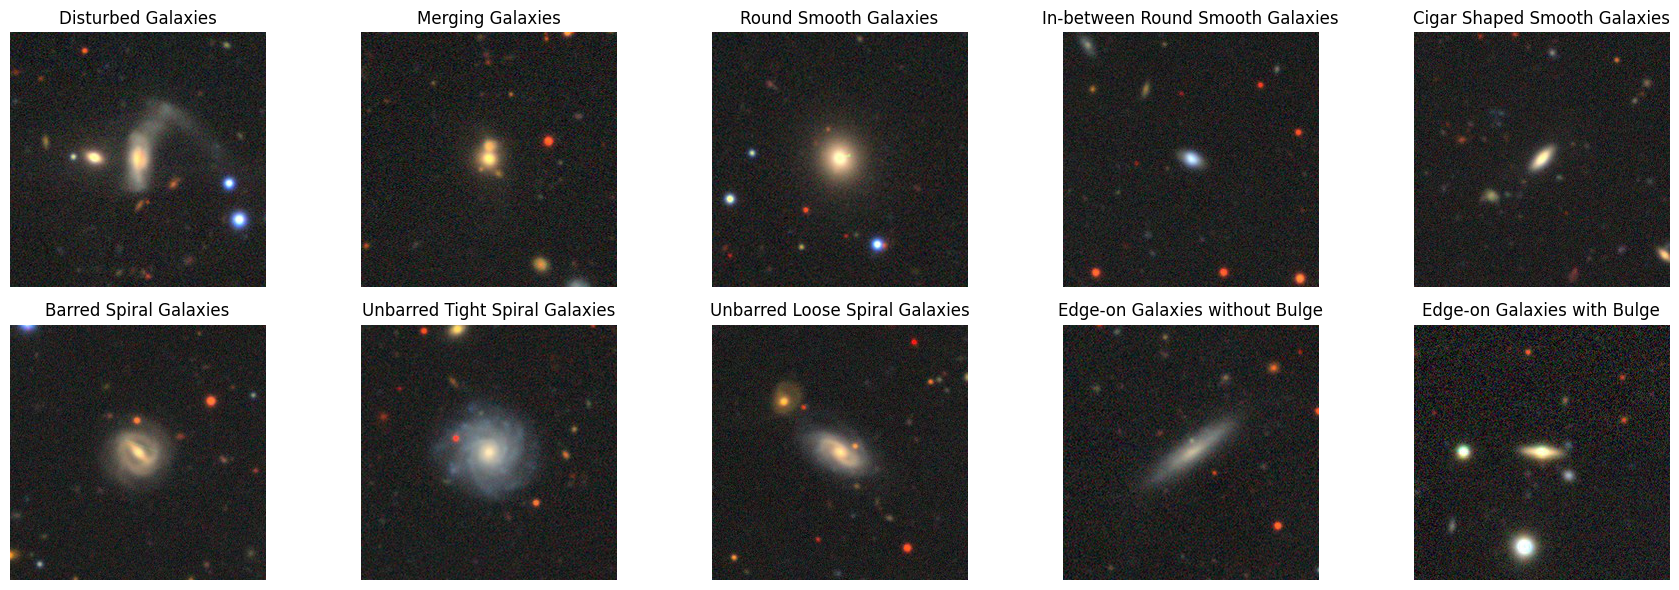


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 142MB/s]


Using 2 GPUs with DataParallel
Epoch [1/20] Completed | Train Loss: 0.9857 Acc: 0.4787 | Val Loss: 1.2607 Acc: 0.5000 | Learning Rate: 0.00100000 | Time: 27.17s
Epoch [2/20] Completed | Train Loss: 0.6380 Acc: 0.6295 | Val Loss: 0.6694 Acc: 0.6138 | Learning Rate: 0.00099385 | Time: 23.83s
Epoch [3/20] Completed | Train Loss: 0.5694 Acc: 0.6669 | Val Loss: 0.4969 Acc: 0.6737 | Learning Rate: 0.00097555 | Time: 23.86s
Epoch [4/20] Completed | Train Loss: 0.5184 Acc: 0.6815 | Val Loss: 0.5349 Acc: 0.6437 | Learning Rate: 0.00094556 | Time: 23.76s
Epoch [5/20] Completed | Train Loss: 0.4198 Acc: 0.7365 | Val Loss: 0.4350 Acc: 0.7275 | Learning Rate: 0.00090460 | Time: 23.93s
Epoch [6/20] Completed | Train Loss: 0.4081 Acc: 0.7418 | Val Loss: 0.5312 Acc: 0.6557 | Learning Rate: 0.00085370 | Time: 23.86s
Epoch [7/20] Completed | Train Loss: 0.3751 Acc: 0.7691 | Val Loss: 0.5501 Acc: 0.6527 | Learning Rate: 0.00079410 | Time: 24.06s
Epoch [8/20] Completed | Train Loss: 0.3081 Acc: 0.7968 | V

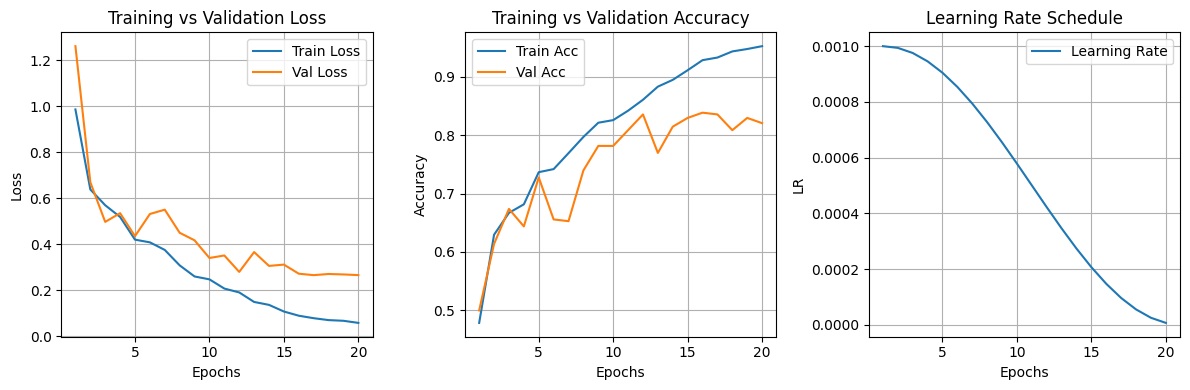


Test Loss: 0.2676, Test Acc: 0.8383, Test Time: 2.44s

Overall (weighted) Precision: 0.8346 Recall: 0.8383 F1: 0.8340 

   class  precision    recall        f1  support
0      0   0.555556  0.454545  0.500000       33
1      1   0.911765  0.939394  0.925373       33
2      2   0.810811  0.909091  0.857143       33
3      3   0.833333  0.882353  0.857143       34
4      4   0.885714  0.911765  0.898551       34
5      5   0.820513  0.941176  0.876712       34
6      6   0.884615  0.696970  0.779661       33
7      7   0.735294  0.735294  0.735294       34
8      8   0.941176  0.969697  0.955224       33
9      9   0.968750  0.939394  0.953846       33


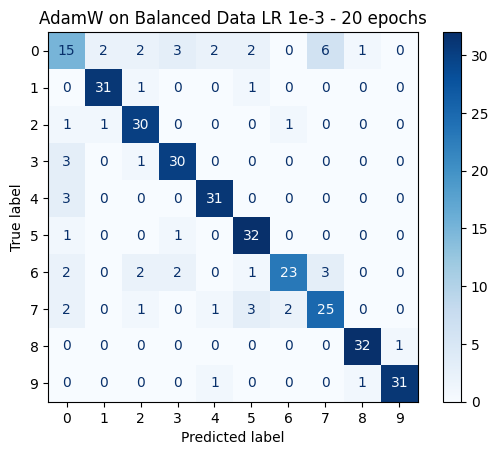


Running Experiment: AdamW on Balanced Data LR 1e-4 - 20 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})

Epoch [1/20] Completed | Train Loss: 1.3185 Acc: 0.3993 | Val Loss: 0.7375 Acc: 0.6198 | Learning Rate: 0.00010000 | Time: 23.82s
Epoch [2/20] Completed | Train Loss: 0.6122 Acc: 0.6826 | Val Loss: 0.5154 Acc: 0.7036 | Learning Rate: 0.00009939 | Time: 24.05s
Epoch [3/20] Completed | Train Loss: 0.4771 Acc: 0.7328 | Val Loss: 0.4301 Acc: 0.7425 | Learning Rate: 0.00009758 | Time: 24.07s
Epoch [4/20] Completed | Train Loss: 0.3831 Acc: 0.7736 | Val Loss: 0.4091 Acc: 0.76

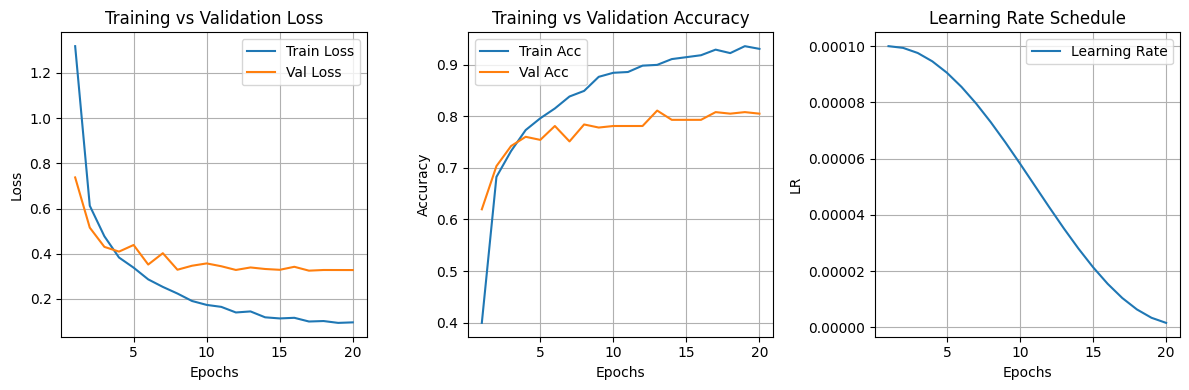


Test Loss: 0.2580, Test Acc: 0.8473, Test Time: 2.54s

Overall (weighted) Precision: 0.8477 Recall: 0.8473 F1: 0.8439 

   class  precision    recall        f1  support
0      0   0.782609  0.545455  0.642857       33
1      1   0.914286  0.969697  0.941176       33
2      2   0.861111  0.939394  0.898551       33
3      3   0.868421  0.970588  0.916667       34
4      4   0.888889  0.941176  0.914286       34
5      5   0.833333  0.735294  0.781250       34
6      6   0.800000  0.727273  0.761905       33
7      7   0.625000  0.735294  0.675676       34
8      8   0.969697  0.969697  0.969697       33
9      9   0.939394  0.939394  0.939394       33


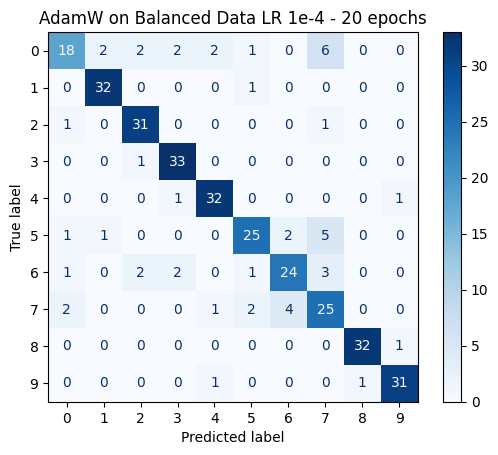


Running Experiment: SGDM on Balanced Data LR 1e-3 - 20 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})

Epoch [1/20] Completed | Train Loss: 1.6735 Acc: 0.2320 | Val Loss: 1.1721 Acc: 0.4341 | Learning Rate: 0.00100000 | Time: 23.95s
Epoch [2/20] Completed | Train Loss: 0.9534 Acc: 0.5277 | Val Loss: 0.6903 Acc: 0.6347 | Learning Rate: 0.00099385 | Time: 23.86s
Epoch [3/20] Completed | Train Loss: 0.6484 Acc: 0.6441 | Val Loss: 0.5214 Acc: 0.6886 | Learning Rate: 0.00097555 | Time: 23.76s
Epoch [4/20] Completed | Train Loss: 0.5351 Acc: 0.6935 | Val Loss: 0.4503 Acc: 0.7216 

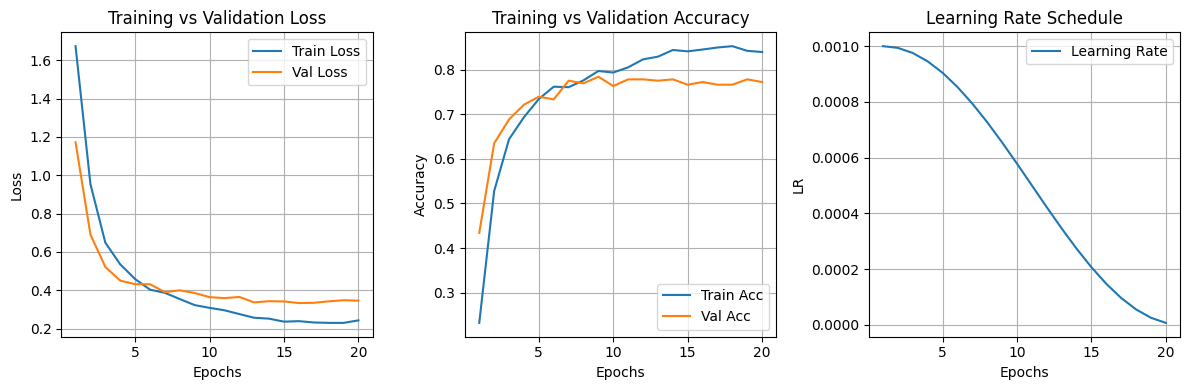


Test Loss: 0.3253, Test Acc: 0.8114, Test Time: 2.47s

Overall (weighted) Precision: 0.8121 Recall: 0.8114 F1: 0.8095 

   class  precision    recall        f1  support
0      0   0.562500  0.545455  0.553846       33
1      1   0.837838  0.939394  0.885714       33
2      2   0.810811  0.909091  0.857143       33
3      3   0.888889  0.941176  0.914286       34
4      4   0.911765  0.911765  0.911765       34
5      5   0.800000  0.705882  0.750000       34
6      6   0.846154  0.666667  0.745763       33
7      7   0.555556  0.588235  0.571429       34
8      8   0.942857  1.000000  0.970588       33
9      9   0.967742  0.909091  0.937500       33


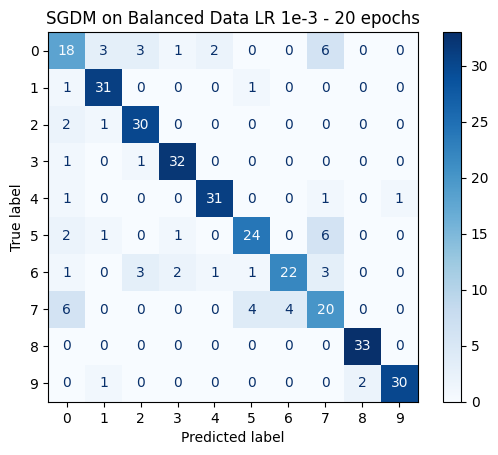


Running Experiment: SGDM on Balanced Data LR 1e-4 - 20 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})

Epoch [1/20] Completed | Train Loss: 1.8911 Acc: 0.1164 | Val Loss: 1.8339 Acc: 0.1347 | Learning Rate: 0.00010000 | Time: 23.73s
Epoch [2/20] Completed | Train Loss: 1.7829 Acc: 0.1793 | Val Loss: 1.7275 Acc: 0.2066 | Learning Rate: 0.00009939 | Time: 23.82s
Epoch [3/20] Completed | Train Loss: 1.6693 Acc: 0.2653 | Val Loss: 1.6147 Acc: 0.2784 | Learning Rate: 0.00009758 | Time: 23.77s
Epoch [4/20] Completed | Train Loss: 1.5564 Acc: 0.3353 | Val Loss: 1.4781 Acc: 0.3772

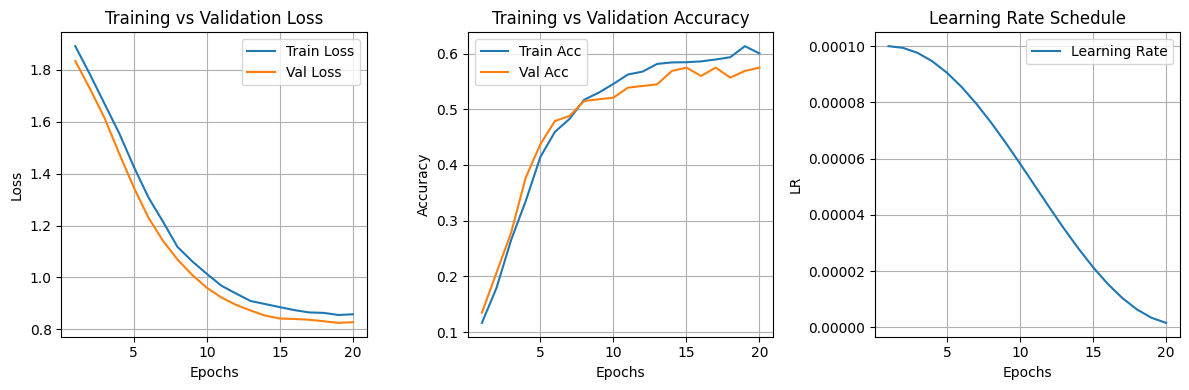


Test Loss: 0.8201, Test Acc: 0.6317, Test Time: 2.52s

Overall (weighted) Precision: 0.6394 Recall: 0.6317 F1: 0.6255 

   class  precision    recall        f1  support
0      0   0.529412  0.272727  0.360000       33
1      1   0.531250  0.515152  0.523077       33
2      2   0.577778  0.787879  0.666667       33
3      3   0.512195  0.617647  0.560000       34
4      4   0.682927  0.823529  0.746667       34
5      5   0.666667  0.529412  0.590164       34
6      6   0.593750  0.575758  0.584615       33
7      7   0.487179  0.558824  0.520548       34
8      8   0.861111  0.939394  0.898551       33
9      9   0.958333  0.696970  0.807018       33


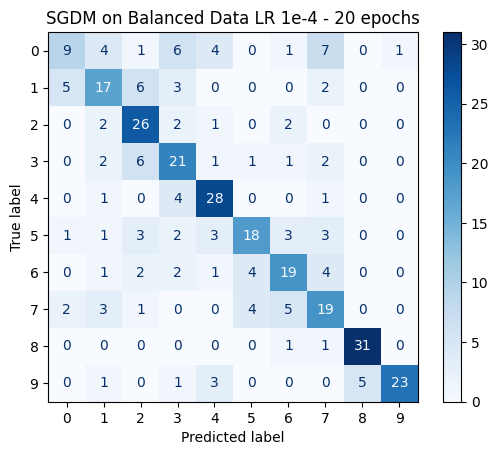


Running Experiment: AdamW on Balanced Data LR 1e-3 - 40 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})

Epoch [1/40] Completed | Train Loss: 1.0131 Acc: 0.4876 | Val Loss: 1.1042 Acc: 0.4910 | Learning Rate: 0.00100000 | Time: 24.04s
Epoch [2/40] Completed | Train Loss: 0.6762 Acc: 0.6070 | Val Loss: 0.8142 Acc: 0.5419 | Learning Rate: 0.00099846 | Time: 23.93s
Epoch [3/40] Completed | Train Loss: 0.5480 Acc: 0.6800 | Val Loss: 0.5415 Acc: 0.7156 | Learning Rate: 0.00099385 | Time: 24.02s
Epoch [4/40] Completed | Train Loss: 0.5245 Acc: 0.6946 | Val Loss: 0.5467 Acc: 0.649

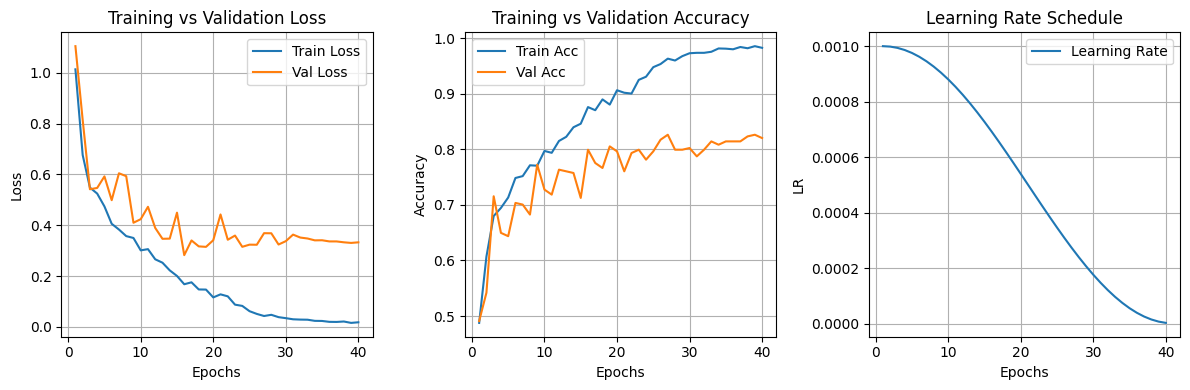


Test Loss: 0.3170, Test Acc: 0.8383, Test Time: 2.48s

Overall (weighted) Precision: 0.8355 Recall: 0.8383 F1: 0.8339 

   class  precision    recall        f1  support
0      0   0.680000  0.515152  0.586207       33
1      1   0.857143  0.909091  0.882353       33
2      2   0.789474  0.909091  0.845070       33
3      3   0.861111  0.911765  0.885714       34
4      4   0.885714  0.911765  0.898551       34
5      5   0.852941  0.852941  0.852941       34
6      6   0.807692  0.636364  0.711864       33
7      7   0.710526  0.794118  0.750000       34
8      8   0.941176  0.969697  0.955224       33
9      9   0.969697  0.969697  0.969697       33


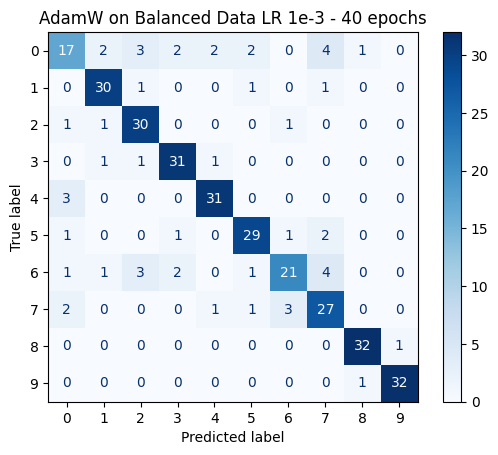


Running Experiment: AdamW on Balanced Data LR 1e-4 - 40 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})

Epoch [1/40] Completed | Train Loss: 1.2422 Acc: 0.4353 | Val Loss: 0.6509 Acc: 0.6677 | Learning Rate: 0.00010000 | Time: 23.93s
Epoch [2/40] Completed | Train Loss: 0.6013 Acc: 0.6774 | Val Loss: 0.4530 Acc: 0.7515 | Learning Rate: 0.00009985 | Time: 23.79s
Epoch [3/40] Completed | Train Loss: 0.4474 Acc: 0.7489 | Val Loss: 0.4094 Acc: 0.7365 | Learning Rate: 0.00009939 | Time: 23.99s
Epoch [4/40] Completed | Train Loss: 0.3880 Acc: 0.7691 | Val Loss: 0.4164 Acc: 0.77

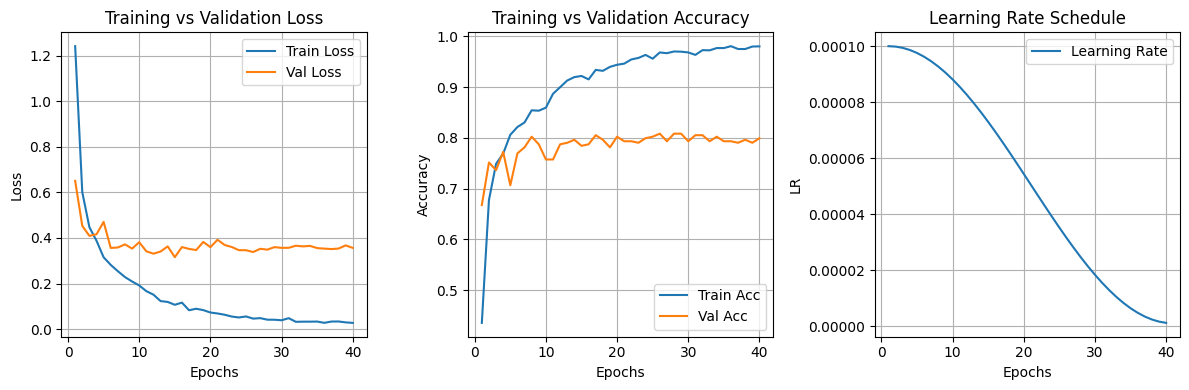


Test Loss: 0.3253, Test Acc: 0.8323, Test Time: 2.55s

Overall (weighted) Precision: 0.8334 Recall: 0.8323 F1: 0.8297 

   class  precision    recall        f1  support
0      0   0.640000  0.484848  0.551724       33
1      1   0.861111  0.939394  0.898551       33
2      2   0.833333  0.909091  0.869565       33
3      3   0.810811  0.882353  0.845070       34
4      4   0.914286  0.941176  0.927536       34
5      5   0.870968  0.794118  0.830769       34
6      6   0.851852  0.696970  0.766667       33
7      7   0.585366  0.705882  0.640000       34
8      8   0.970588  1.000000  0.985075       33
9      9   1.000000  0.969697  0.984615       33


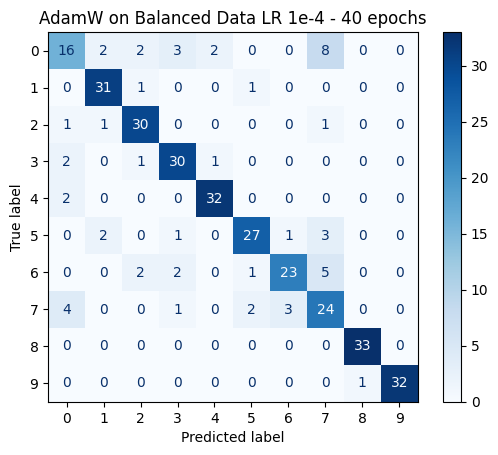


Running Experiment: SGDM on Balanced Data LR 1e-3 - 40 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})

Epoch [1/40] Completed | Train Loss: 1.6176 Acc: 0.2713 | Val Loss: 1.0844 Acc: 0.4671 | Learning Rate: 0.00100000 | Time: 23.68s
Epoch [2/40] Completed | Train Loss: 0.8921 Acc: 0.5632 | Val Loss: 0.6360 Acc: 0.6587 | Learning Rate: 0.00099846 | Time: 23.99s
Epoch [3/40] Completed | Train Loss: 0.6005 Acc: 0.6703 | Val Loss: 0.5071 Acc: 0.7096 | Learning Rate: 0.00099385 | Time: 23.88s
Epoch [4/40] Completed | Train Loss: 0.4992 Acc: 0.7242 | Val Loss: 0.4500 Acc: 0.7365 

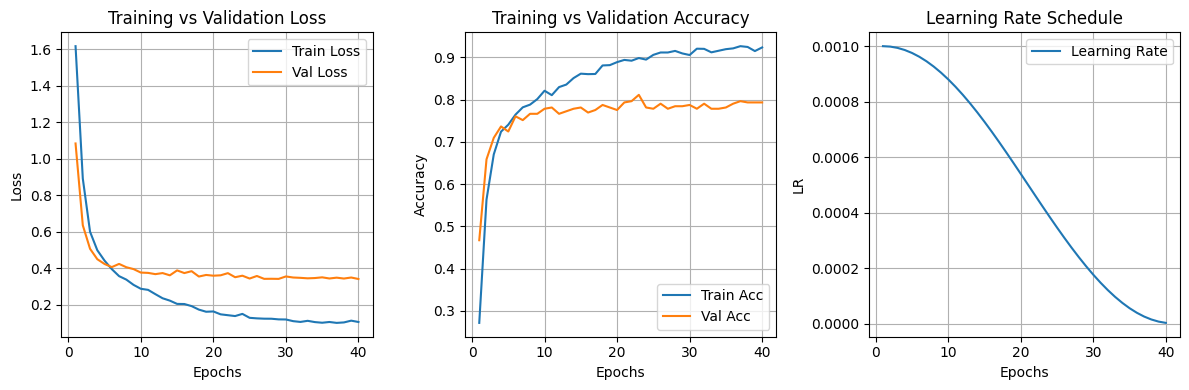


Test Loss: 0.2771, Test Acc: 0.8473, Test Time: 2.56s

Overall (weighted) Precision: 0.8447 Recall: 0.8473 F1: 0.8439 

   class  precision    recall        f1  support
0      0   0.730769  0.575758  0.644068       33
1      1   0.864865  0.969697  0.914286       33
2      2   0.833333  0.909091  0.869565       33
3      3   0.837838  0.911765  0.873239       34
4      4   0.941176  0.941176  0.941176       34
5      5   0.783784  0.852941  0.816901       34
6      6   0.862069  0.757576  0.806452       33
7      7   0.687500  0.647059  0.666667       34
8      8   0.941176  0.969697  0.955224       33
9      9   0.968750  0.939394  0.953846       33


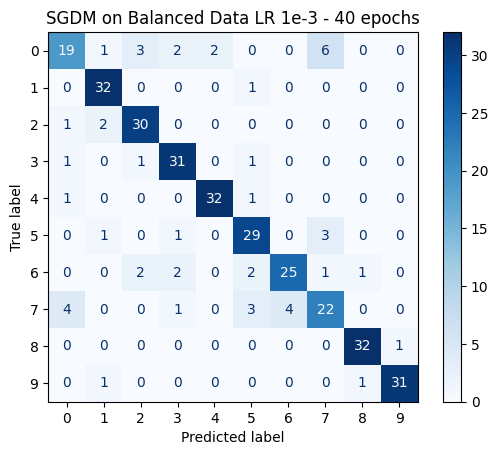


Running Experiment: SGDM on Balanced Data LR 1e-4 - 40 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: True


Train: 2672 Val: 334 Test: 334
Train class counts: Counter({1: 268, 8: 268, 2: 267, 7: 267, 6: 267, 9: 267, 3: 267, 5: 267, 0: 267, 4: 267})
Val class counts: Counter({6: 34, 0: 34, 9: 34, 2: 34, 7: 33, 3: 33, 4: 33, 1: 33, 5: 33, 8: 33})
Test class counts: Counter({5: 34, 7: 34, 4: 34, 3: 34, 0: 33, 2: 33, 1: 33, 8: 33, 9: 33, 6: 33})

Epoch [1/40] Completed | Train Loss: 1.9017 Acc: 0.1134 | Val Loss: 1.8384 Acc: 0.1467 | Learning Rate: 0.00010000 | Time: 24.08s
Epoch [2/40] Completed | Train Loss: 1.8015 Acc: 0.1699 | Val Loss: 1.7403 Acc: 0.2455 | Learning Rate: 0.00009985 | Time: 24.01s
Epoch [3/40] Completed | Train Loss: 1.6990 Acc: 0.2373 | Val Loss: 1.6314 Acc: 0.2994 | Learning Rate: 0.00009939 | Time: 24.07s
Epoch [4/40] Completed | Train Loss: 1.5913 Acc: 0.3147 | Val Loss: 1.5107 Acc: 0.3772

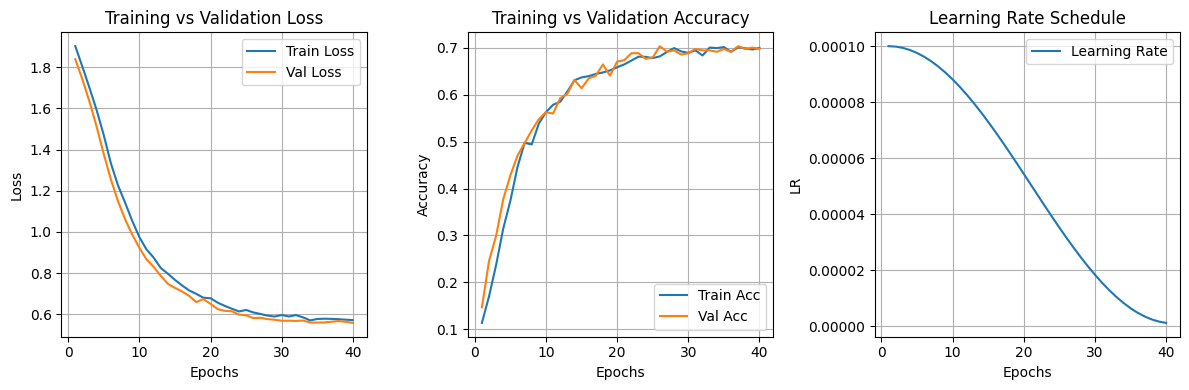


Test Loss: 0.5145, Test Acc: 0.7425, Test Time: 2.52s

Overall (weighted) Precision: 0.7424 Recall: 0.7425 F1: 0.7348 

   class  precision    recall        f1  support
0      0   0.700000  0.424242  0.528302       33
1      1   0.650000  0.787879  0.712329       33
2      2   0.717949  0.848485  0.777778       33
3      3   0.735294  0.735294  0.735294       34
4      4   0.769231  0.882353  0.821918       34
5      5   0.685714  0.705882  0.695652       34
6      6   0.648649  0.727273  0.685714       33
7      7   0.695652  0.470588  0.561404       34
8      8   0.888889  0.969697  0.927536       33
9      9   0.935484  0.878788  0.906250       33


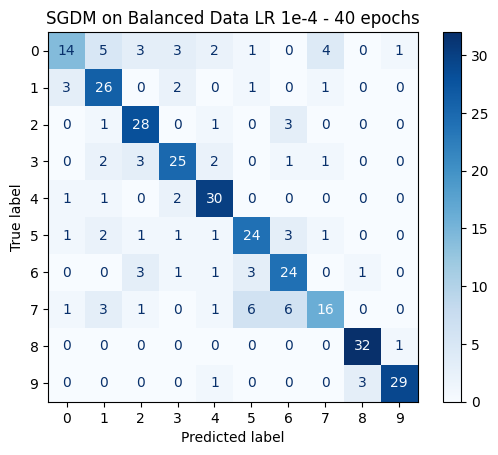


Experiments with Balanced Data completed. Summary saved.


In [14]:
# ------------------ Experiments on Balanced Data ------------------
EXPERIMENTS = [
    {"exp_name":"AdamW on Balanced Data LR 1e-3 - 20 epochs", "dataset_balanced":True, "lr":1e-3, "optimizer_name":"AdamW",  "num_of_epochs":20},
    {"exp_name":"AdamW on Balanced Data LR 1e-4 - 20 epochs", "dataset_balanced":True, "lr":1e-4, "optimizer_name":"AdamW",  "num_of_epochs":20},
    {"exp_name":"SGDM on Balanced Data LR 1e-3 - 20 epochs", "dataset_balanced":True, "lr":1e-3, "optimizer_name":"SGDM",  "num_of_epochs":20},
    {"exp_name":"SGDM on Balanced Data LR 1e-4 - 20 epochs", "dataset_balanced":True, "lr":1e-4, "optimizer_name":"SGDM",  "num_of_epochs":20},
    {"exp_name":"AdamW on Balanced Data LR 1e-3 - 40 epochs", "dataset_balanced":True, "lr":1e-3, "optimizer_name":"AdamW",  "num_of_epochs":40},
    {"exp_name":"AdamW on Balanced Data LR 1e-4 - 40 epochs", "dataset_balanced":True, "lr":1e-4, "optimizer_name":"AdamW",  "num_of_epochs":40},
    {"exp_name":"SGDM on Balanced Data LR 1e-3 - 40 epochs", "dataset_balanced":True, "lr":1e-3, "optimizer_name":"SGDM",  "num_of_epochs":40},
    {"exp_name":"SGDM on Balanced Data LR 1e-4 - 40 epochs", "dataset_balanced":True, "lr":1e-4, "optimizer_name":"SGDM",  "num_of_epochs":40},
    ]

balanced_results = []
for exp in EXPERIMENTS:
    res = run_experiment(**exp)
    balanced_results.append(res)

pd.DataFrame(balanced_results).to_csv(CFG.experiments_with_balanced_csv, index=False)
print("\nExperiments with Balanced Data completed. Summary saved.")


Running Experiment: AdamW on Imbalanced Data LR 1e-3 - 20 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/20] Completed | Train Loss: 0.5402 Acc: 0.5741 | Val Loss: 0.6329 Acc: 0.5158 | Learning Rate: 0.00100000 | Time: 121.80s
Epoch [2/20] Completed | Train Loss: 0.3647 Acc: 0.6951 | Val Loss: 0.3868 Acc: 0.7120 | Learning Rate: 0.00099385 | Time: 120.93s
Epoch [3/20] Completed | Train Loss: 0.3049 Acc: 0.7347 | Val Loss: 0.3042 Acc: 0.7373 | Learning Rate: 0.00097555 | Time: 120.97s
Epoch [4/20] Completed | Train Loss: 0.2688 Acc: 0

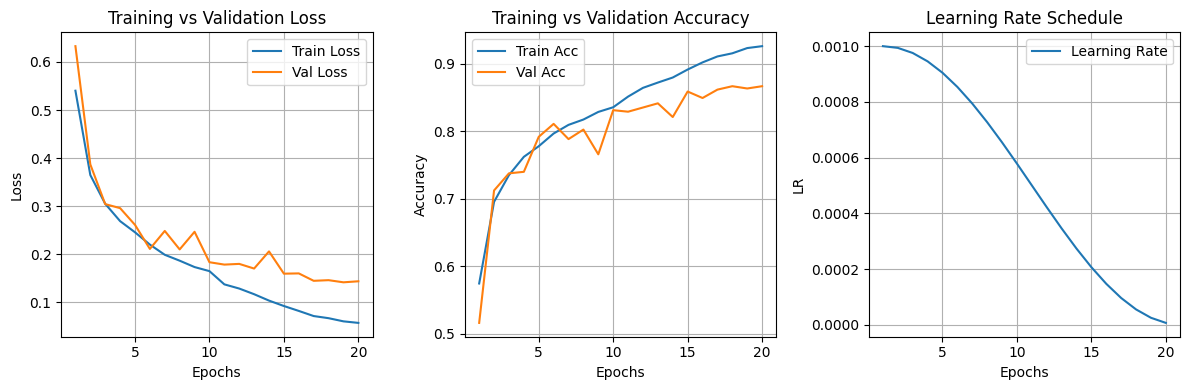


Test Loss: 0.1369, Test Acc: 0.8692, Test Time: 10.29s

Overall (weighted) Precision: 0.8684 Recall: 0.8692 F1: 0.8679 

   class  precision    recall        f1  support
0      0   0.606061  0.555556  0.579710      108
1      1   0.910526  0.935135  0.922667      185
2      2   0.940520  0.958333  0.949343      264
3      3   0.935644  0.931034  0.933333      203
4      4   0.717391  0.970588  0.825000       34
5      5   0.905000  0.882927  0.893827      205
6      6   0.770408  0.825137  0.796834      183
7      7   0.810127  0.730038  0.768000      263
8      8   0.929078  0.922535  0.925795      142
9      9   0.922680  0.957219  0.939633      187


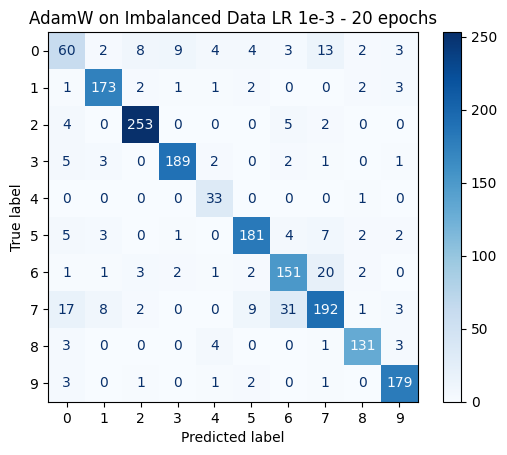


Running Experiment: AdamW on Imbalanced Data LR 1e-4 - 20 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/20] Completed | Train Loss: 0.4928 Acc: 0.6472 | Val Loss: 0.2518 Acc: 0.7762 | Learning Rate: 0.00010000 | Time: 121.11s
Epoch [2/20] Completed | Train Loss: 0.2717 Acc: 0.7713 | Val Loss: 0.2553 Acc: 0.7931 | Learning Rate: 0.00009939 | Time: 121.49s
Epoch [3/20] Completed | Train Loss: 0.2212 Acc: 0.8068 | Val Loss: 0.1934 Acc: 0.8253 | Learning Rate: 0.00009758 | Time: 121.31s
Epoch [4/20] Completed | Train Loss: 0.1956 Acc: 

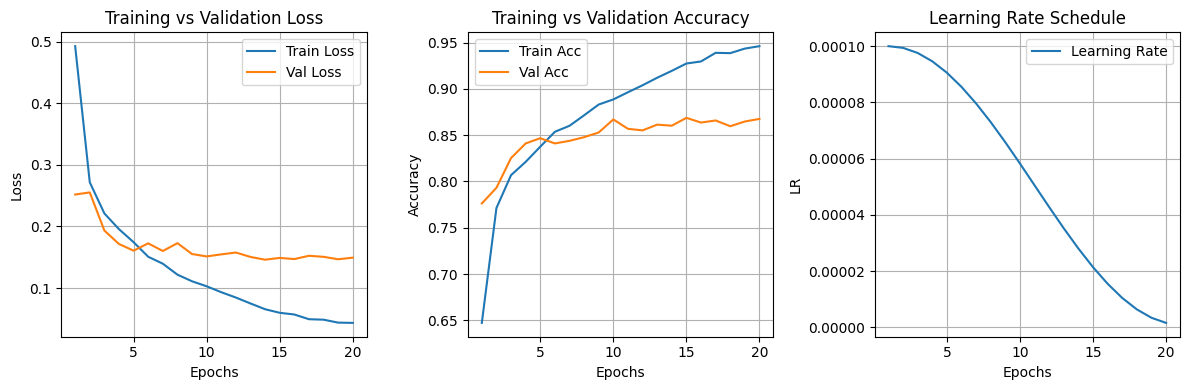


Test Loss: 0.1566, Test Acc: 0.8608, Test Time: 10.03s

Overall (weighted) Precision: 0.8592 Recall: 0.8608 F1: 0.8591 

   class  precision    recall        f1  support
0      0   0.574713  0.462963  0.512821      108
1      1   0.899471  0.918919  0.909091      185
2      2   0.915129  0.939394  0.927103      264
3      3   0.935961  0.935961  0.935961      203
4      4   0.785714  0.970588  0.868421       34
5      5   0.932292  0.873171  0.901763      205
6      6   0.745000  0.814208  0.778068      183
7      7   0.752852  0.752852  0.752852      263
8      8   0.949275  0.922535  0.935714      142
9      9   0.947090  0.957219  0.952128      187


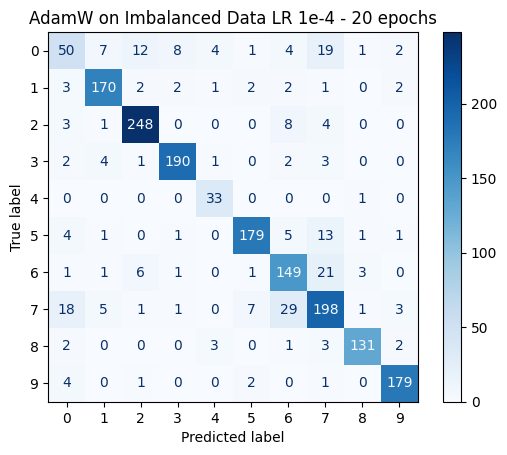


Running Experiment: SGDM on Imbalanced Data LR 1e-3 - 20 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/20] Completed | Train Loss: 0.6851 Acc: 0.5284 | Val Loss: 0.3335 Acc: 0.7193 | Learning Rate: 0.00100000 | Time: 119.59s
Epoch [2/20] Completed | Train Loss: 0.3259 Acc: 0.7399 | Val Loss: 0.2583 Acc: 0.7717 | Learning Rate: 0.00099385 | Time: 119.88s
Epoch [3/20] Completed | Train Loss: 0.2647 Acc: 0.7723 | Val Loss: 0.2195 Acc: 0.7920 | Learning Rate: 0.00097555 | Time: 120.16s
Epoch [4/20] Completed | Train Loss: 0.2357 Acc: 0.7

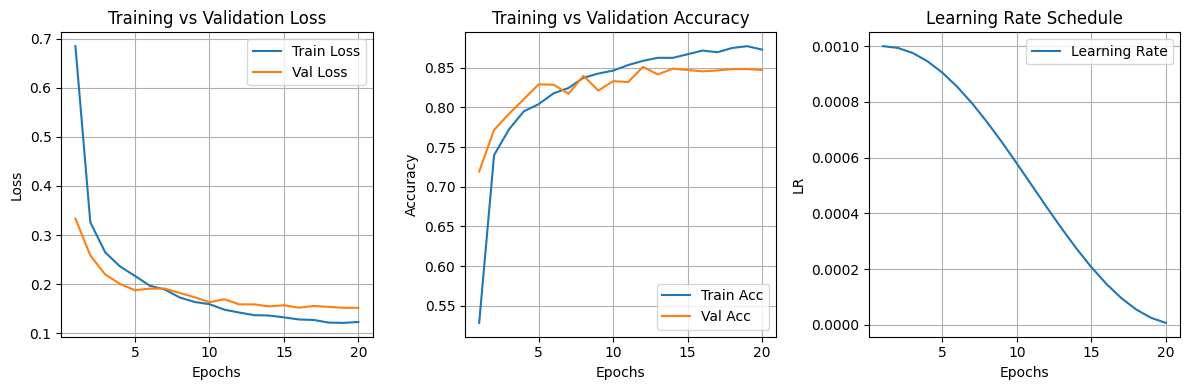


Test Loss: 0.1578, Test Acc: 0.8450, Test Time: 10.43s

Overall (weighted) Precision: 0.8447 Recall: 0.8450 F1: 0.8437 

   class  precision    recall        f1  support
0      0   0.604396  0.509259  0.552764      108
1      1   0.883598  0.902703  0.893048      185
2      2   0.942529  0.931818  0.937143      264
3      3   0.908213  0.926108  0.917073      203
4      4   0.660000  0.970588  0.785714       34
5      5   0.867647  0.863415  0.865526      205
6      6   0.713568  0.775956  0.743455      183
7      7   0.752033  0.703422  0.726916      263
8      8   0.930070  0.936620  0.933333      142
9      9   0.940217  0.925134  0.932615      187


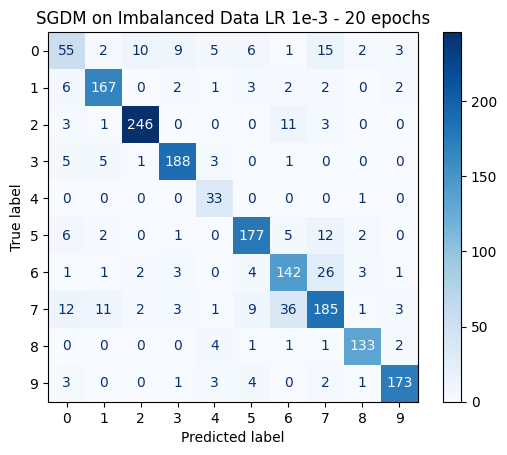


Running Experiment: SGDM on Imbalanced Data LR 1e-4 - 20 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/20] Completed | Train Loss: 1.2879 Acc: 0.2124 | Val Loss: 1.1172 Acc: 0.3867 | Learning Rate: 0.00010000 | Time: 119.93s
Epoch [2/20] Completed | Train Loss: 0.9780 Acc: 0.4236 | Val Loss: 0.7752 Acc: 0.5282 | Learning Rate: 0.00009939 | Time: 120.57s
Epoch [3/20] Completed | Train Loss: 0.7241 Acc: 0.5380 | Val Loss: 0.5797 Acc: 0.6099 | Learning Rate: 0.00009758 | Time: 120.48s
Epoch [4/20] Completed | Train Loss: 0.5801 Acc: 0.

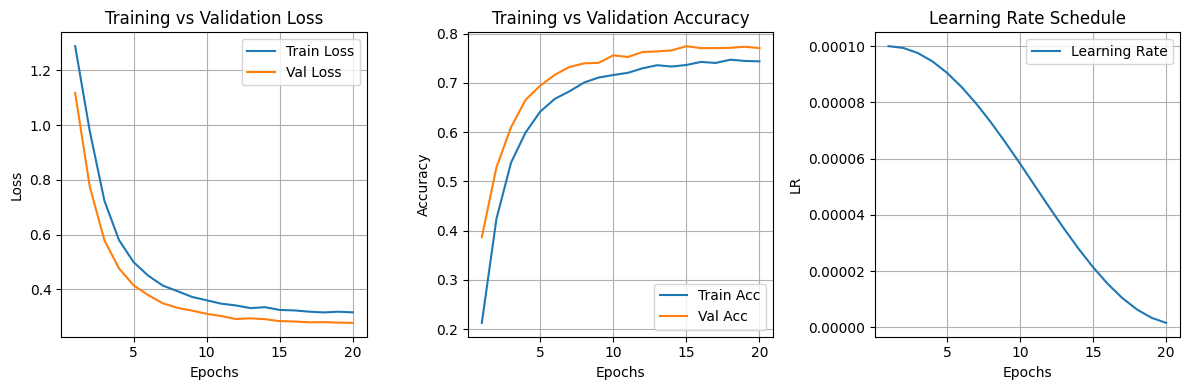


Test Loss: 0.2765, Test Acc: 0.7604, Test Time: 10.31s

Overall (weighted) Precision: 0.7619 Recall: 0.7604 F1: 0.7589 

   class  precision    recall        f1  support
0      0   0.444444  0.370370  0.404040      108
1      1   0.756906  0.740541  0.748634      185
2      2   0.870036  0.912879  0.890943      264
3      3   0.868687  0.847291  0.857855      203
4      4   0.492537  0.970588  0.653465       34
5      5   0.815217  0.731707  0.771208      205
6      6   0.650000  0.710383  0.678851      183
7      7   0.617886  0.577947  0.597250      263
8      8   0.881944  0.894366  0.888112      142
9      9   0.893048  0.893048  0.893048      187


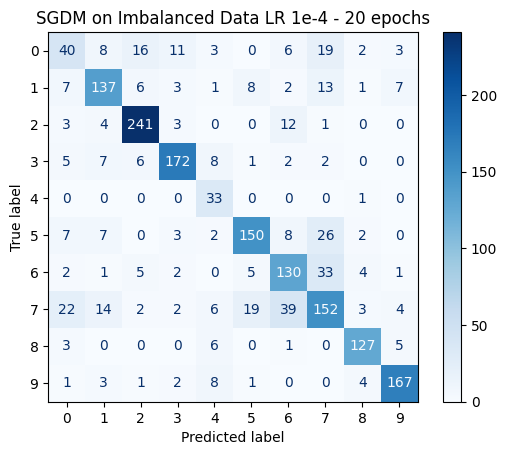


Running Experiment: AdamW on Imbalanced Data LR 1e-3 - 40 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/40] Completed | Train Loss: 0.5295 Acc: 0.5973 | Val Loss: 0.4789 Acc: 0.6240 | Learning Rate: 0.00100000 | Time: 121.12s
Epoch [2/40] Completed | Train Loss: 0.3586 Acc: 0.6990 | Val Loss: 0.3385 Acc: 0.7283 | Learning Rate: 0.00099846 | Time: 120.67s
Epoch [3/40] Completed | Train Loss: 0.3089 Acc: 0.7360 | Val Loss: 0.3295 Acc: 0.7508 | Learning Rate: 0.00099385 | Time: 120.66s
Epoch [4/40] Completed | Train Loss: 0.2611 Acc: 0

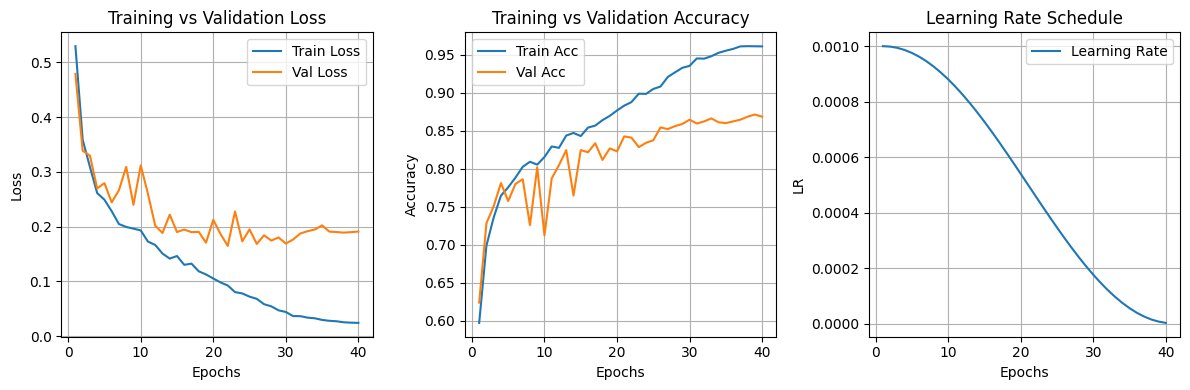


Test Loss: 0.1758, Test Acc: 0.8557, Test Time: 10.13s

Overall (weighted) Precision: 0.8545 Recall: 0.8557 F1: 0.8544 

   class  precision    recall        f1  support
0      0   0.603960  0.564815  0.583732      108
1      1   0.924731  0.929730  0.927224      185
2      2   0.921933  0.939394  0.930582      264
3      3   0.922705  0.940887  0.931707      203
4      4   0.744186  0.941176  0.831169       34
5      5   0.878641  0.882927  0.880779      205
6      6   0.730570  0.770492  0.750000      183
7      7   0.781513  0.707224  0.742515      263
8      8   0.928058  0.908451  0.918149      142
9      9   0.921875  0.946524  0.934037      187


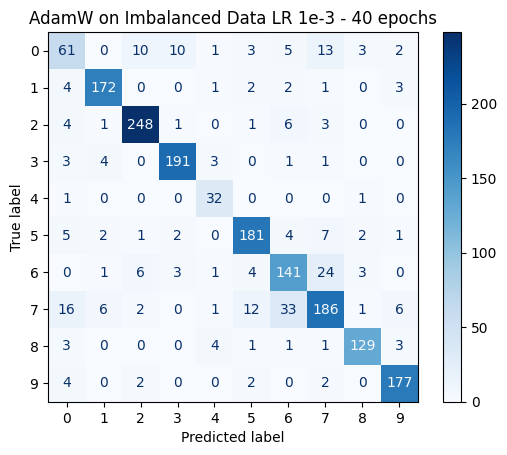


Running Experiment: AdamW on Imbalanced Data LR 1e-4 - 40 epochs
Model: DenseNet121, Optimizer: AdamW, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/40] Completed | Train Loss: 0.4951 Acc: 0.6469 | Val Loss: 0.2623 Acc: 0.7728 | Learning Rate: 0.00010000 | Time: 121.59s
Epoch [2/40] Completed | Train Loss: 0.2672 Acc: 0.7759 | Val Loss: 0.2167 Acc: 0.8055 | Learning Rate: 0.00009985 | Time: 121.45s
Epoch [3/40] Completed | Train Loss: 0.2279 Acc: 0.8036 | Val Loss: 0.1930 Acc: 0.8219 | Learning Rate: 0.00009939 | Time: 121.02s
Epoch [4/40] Completed | Train Loss: 0.1963 Acc: 

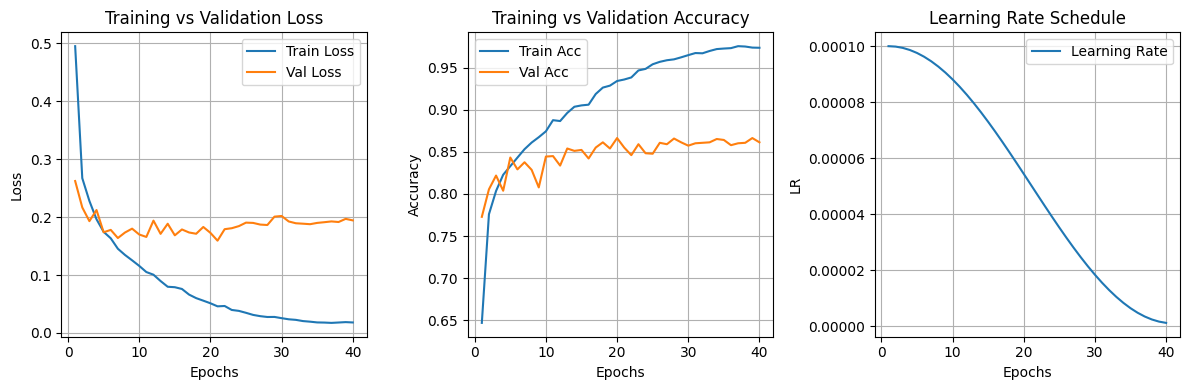


Test Loss: 0.1997, Test Acc: 0.8608, Test Time: 10.10s

Overall (weighted) Precision: 0.8581 Recall: 0.8608 F1: 0.8589 

   class  precision    recall        f1  support
0      0   0.597826  0.509259  0.550000      108
1      1   0.903226  0.908108  0.905660      185
2      2   0.922794  0.950758  0.936567      264
3      3   0.922705  0.940887  0.931707      203
4      4   0.744186  0.941176  0.831169       34
5      5   0.893204  0.897561  0.895377      205
6      6   0.754011  0.770492  0.762162      183
7      7   0.768924  0.733840  0.750973      263
8      8   0.937063  0.943662  0.940351      142
9      9   0.951872  0.951872  0.951872      187


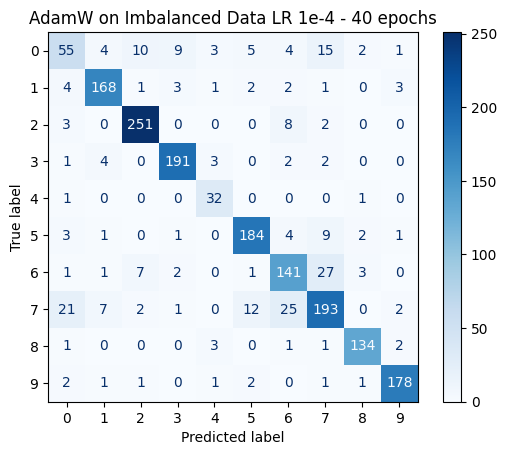


Running Experiment: SGDM on Imbalanced Data LR 1e-3 - 40 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/40] Completed | Train Loss: 0.6873 Acc: 0.5265 | Val Loss: 0.3287 Acc: 0.7311 | Learning Rate: 0.00100000 | Time: 120.34s
Epoch [2/40] Completed | Train Loss: 0.3266 Acc: 0.7295 | Val Loss: 0.2485 Acc: 0.7745 | Learning Rate: 0.00099846 | Time: 119.96s
Epoch [3/40] Completed | Train Loss: 0.2766 Acc: 0.7671 | Val Loss: 0.2323 Acc: 0.7926 | Learning Rate: 0.00099385 | Time: 119.96s
Epoch [4/40] Completed | Train Loss: 0.2366 Acc: 0.7

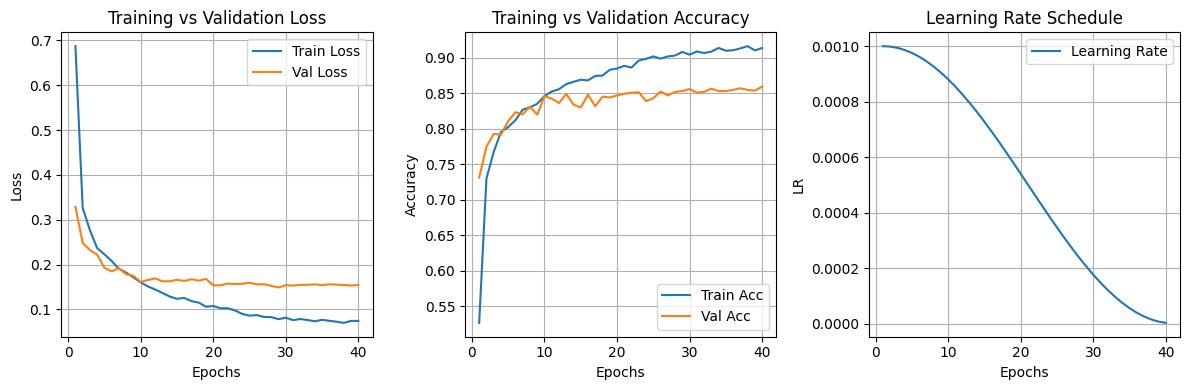


Test Loss: 0.1571, Test Acc: 0.8450, Test Time: 10.21s

Overall (weighted) Precision: 0.8425 Recall: 0.8450 F1: 0.8427 

   class  precision    recall        f1  support
0      0   0.577778  0.481481  0.525253      108
1      1   0.902703  0.902703  0.902703      185
2      2   0.918216  0.935606  0.926829      264
3      3   0.907767  0.921182  0.914425      203
4      4   0.733333  0.970588  0.835443       34
5      5   0.834906  0.863415  0.848921      205
6      6   0.732323  0.792350  0.761155      183
7      7   0.768908  0.695817  0.730539      263
8      8   0.923077  0.929577  0.926316      142
9      9   0.936170  0.941176  0.938667      187


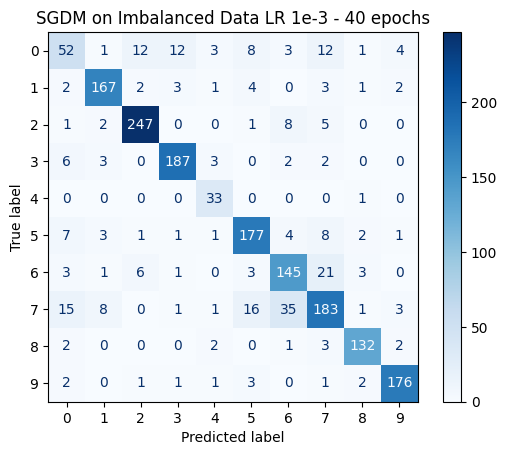


Running Experiment: SGDM on Imbalanced Data LR 1e-4 - 40 epochs
Model: DenseNet121, Optimizer: SGDM, LR: 0.0001, Scheduler: CosineAnnealingLR, Loss: Focal Loss, Dataset Balanced: False


Train: 14188 Val: 1774 Test: 1774
Train class counts: Counter({2: 2116, 7: 2102, 5: 1634, 3: 1622, 9: 1498, 1: 1482, 6: 1463, 8: 1139, 0: 865, 4: 267})
Val class counts: Counter({2: 265, 7: 263, 5: 204, 3: 202, 9: 188, 1: 186, 6: 183, 8: 142, 0: 108, 4: 33})
Test class counts: Counter({2: 264, 7: 263, 5: 205, 3: 203, 9: 187, 1: 185, 6: 183, 8: 142, 0: 108, 4: 34})

Epoch [1/40] Completed | Train Loss: 1.2809 Acc: 0.2057 | Val Loss: 1.1091 Acc: 0.3506 | Learning Rate: 0.00010000 | Time: 120.38s
Epoch [2/40] Completed | Train Loss: 0.9889 Acc: 0.3906 | Val Loss: 0.7936 Acc: 0.4882 | Learning Rate: 0.00009985 | Time: 119.95s
Epoch [3/40] Completed | Train Loss: 0.7398 Acc: 0.5027 | Val Loss: 0.5965 Acc: 0.5970 | Learning Rate: 0.00009939 | Time: 119.75s
Epoch [4/40] Completed | Train Loss: 0.5959 Acc: 0.

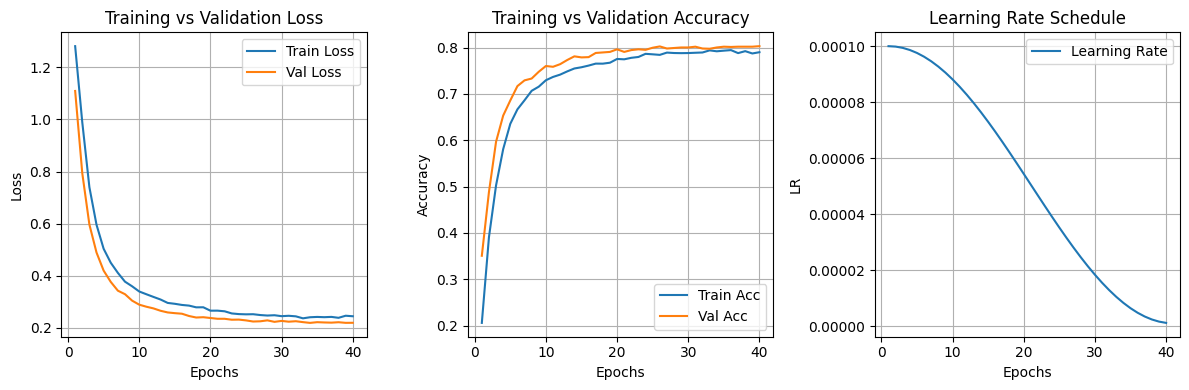


Test Loss: 0.2164, Test Acc: 0.8016, Test Time: 10.06s

Overall (weighted) Precision: 0.8012 Recall: 0.8016 F1: 0.7993 

   class  precision    recall        f1  support
0      0   0.472527  0.398148  0.432161      108
1      1   0.795000  0.859459  0.825974      185
2      2   0.910112  0.920455  0.915254      264
3      3   0.898990  0.876847  0.887781      203
4      4   0.524590  0.941176  0.673684       34
5      5   0.807512  0.839024  0.822967      205
6      6   0.706806  0.737705  0.721925      183
7      7   0.699115  0.600760  0.646217      263
8      8   0.921429  0.908451  0.914894      142
9      9   0.925134  0.925134  0.925134      187


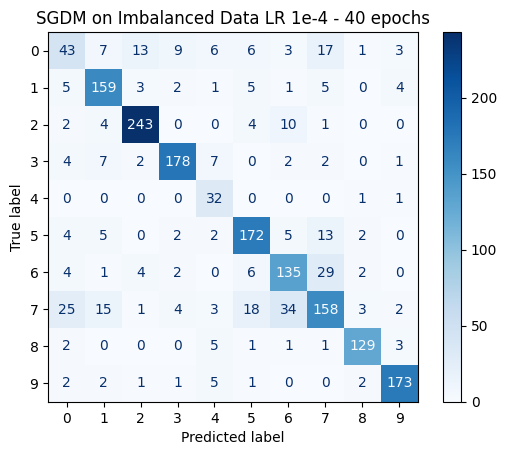


Experiments with Imbalanced Data completed. Summary saved.

All experiments completed. Summary saved.


In [15]:
# ------------------ Experiments on Imbalanced Data ------------------
EXPERIMENTS = [
    {"exp_name":"AdamW on Imbalanced Data LR 1e-3 - 20 epochs", "dataset_balanced":False, "lr":1e-3, "optimizer_name":"AdamW",  "num_of_epochs":20},
    {"exp_name":"AdamW on Imbalanced Data LR 1e-4 - 20 epochs", "dataset_balanced":False, "lr":1e-4, "optimizer_name":"AdamW",  "num_of_epochs":20},
    {"exp_name":"SGDM on Imbalanced Data LR 1e-3 - 20 epochs", "dataset_balanced":False, "lr":1e-3, "optimizer_name":"SGDM",  "num_of_epochs":20},
    {"exp_name":"SGDM on Imbalanced Data LR 1e-4 - 20 epochs", "dataset_balanced":False, "lr":1e-4, "optimizer_name":"SGDM",  "num_of_epochs":20},
    {"exp_name":"AdamW on Imbalanced Data LR 1e-3 - 40 epochs", "dataset_balanced":False, "lr":1e-3, "optimizer_name":"AdamW",  "num_of_epochs":40},
    {"exp_name":"AdamW on Imbalanced Data LR 1e-4 - 40 epochs", "dataset_balanced":False, "lr":1e-4, "optimizer_name":"AdamW",  "num_of_epochs":40},
    {"exp_name":"SGDM on Imbalanced Data LR 1e-3 - 40 epochs", "dataset_balanced":False, "lr":1e-3, "optimizer_name":"SGDM",  "num_of_epochs":40},
    {"exp_name":"SGDM on Imbalanced Data LR 1e-4 - 40 epochs", "dataset_balanced":False, "lr":1e-4, "optimizer_name":"SGDM",  "num_of_epochs":40}
    ]

results = balanced_results
imbalanced_results = []
for exp in EXPERIMENTS:
    res = run_experiment(**exp)
    imbalanced_results.append(res)
    results.append(res)

pd.DataFrame(imbalanced_results).to_csv(CFG.experiments_with_imbalanced_csv, index=False)
print("\nExperiments with Imbalanced Data completed. Summary saved.")

pd.DataFrame(results).to_csv(CFG.experiments_summary_csv, index=False)
print("\nAll experiments completed. Summary saved.")